# UPDRS Self Mutual Information

**The Question:**
For each dimension of score, how much mutual information does previous measures contain?

**Approach:**
1. Load data from `train_clinical_data`, do data preprocessing.
    - *there are many things to do, add in the list*
    - for each record, inputs are:
        - previous clinical data;
        - outputs: propagation value

2. Refine information from the UPDRS data:
    - delta-change from previous UPDRS scoring
    - recent measurements in four UPDRS scores, and their corresponding sampling time points

3. Analyze mutual information (MI) between:
    - previous UPDRS 1 and UPDRS 1
    - previous UPDRS 1, 2, 3 and UPDRS 1

Examine how much information is missing from UPDRS alone. We are expecting to obtain from proteins and peptide measures.
    

**UPDRS measures and definitions**
| Part | Definition |
| --- | --- |
| I | Mentation, Behavior, Mood. |
| II | Activities of Daily Living |
| III | Motor Examination |
| IV | Complications of Therapy |

Read `train_clinical_data`, and get visualiszation of four UPDRS measures.

## A. Data Exploration

Load data from the csv file, view overall dataset distributions and sample patient propagations.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from jpype import *
from preprocessing.paths import pointwise_features_path


# start the JVM kernel
jarLocation = R"G:\My Drive\CRS_CSYS5030\jidt\infodynamics.jar"
if (not(os.path.isfile(jarLocation))):
    raise FileNotFoundError(f"infordynamics.jar file not found: {jarLocation}")
startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

DATA_DIR = R"D:\data\amp-pd-data"
clinical_data_path = os.path.join(DATA_DIR, 'train_clinical_data.csv')
clinical_data = pd.read_csv(clinical_data_path)
df_e1 = pd.read_csv(pointwise_features_path)

### Overall data distribution

Distribution of 4 dimensions of UPDRS scores on record.

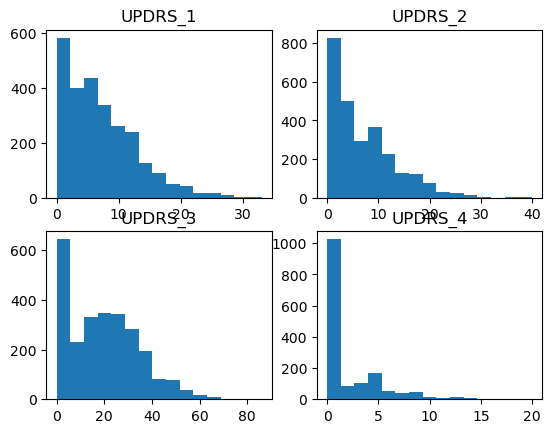

In [4]:
fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
for i in range(4):
    ax = ax_flat[i]
    assert isinstance(ax, Axes)
    updrs_dimension = clinical_data[f'updrs_{int(i+1)}']
    updrs_dimension = updrs_dimension[updrs_dimension.notna()]
    ax.set_title(f'UPDRS_{int(i+1)}')
    ax.hist(updrs_dimension, bins=15)

### Patient profile features
See the highest UPDRS scores in each fields which each patient can reach. This will give an idea of how to separate into stages. (Calculate how long it takes to reach the stage)

### Highest UPDRS reachable

What is the distribution of highest UPDRS a patient can reach?

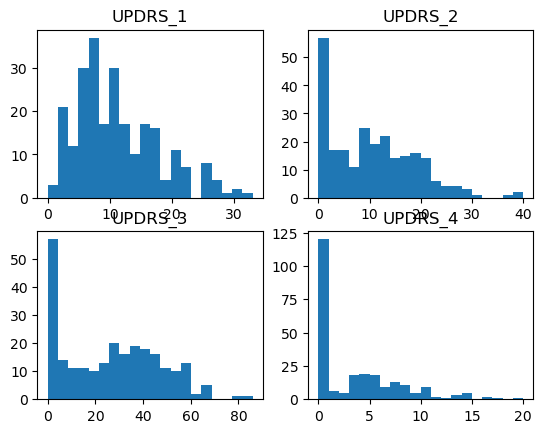

In [5]:
clinical_data_profile = clinical_data.copy()  # this df is for use by experiment 1 only.
clinical_data_profile.rename(
    columns={
        'upd23b_clinical_state_on_medication': 'on_medication',
        'visit_month': 'month'
        }, inplace=True)
clinical_data_profile.drop(columns=['on_medication'])
df_profile = clinical_data_profile.groupby(['patient_id'])

# plotting the distribution of maximum UPDRS reachable
max_updrs = df_profile[[f"updrs_{i}" for i in (1,2,3,4)]].max()
max_updrs = max_updrs.fillna(0) # if all columns are missing, then max is 0

fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
for i in (1,2,3,4):
    ax = ax_flat[i-1]
    assert isinstance(ax, Axes)
    updrs_dimension = max_updrs[f'updrs_{i}']
    updrs_dimension = updrs_dimension[updrs_dimension.notna()]
    ax.set_title(f'UPDRS_{i}')
    ax.hist(updrs_dimension, bins=20)


**Question:** How much mutual information does max UPDRS values hold about other UPDRS values?

Clustering patient profiles, by the maximum UPDRS scores in 4 dimensions

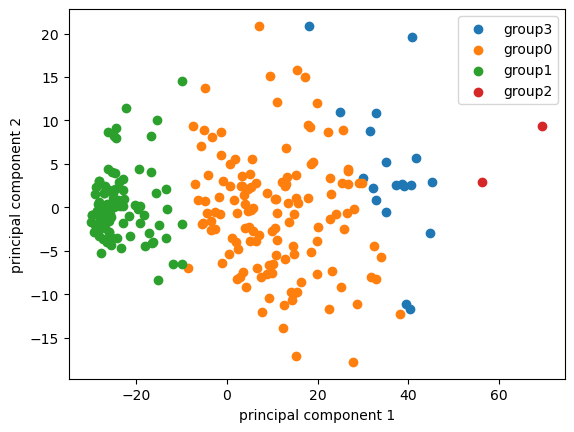

In [6]:
# kmeans clustering for max updrs features
# clf = KMeans(n_clusters=3)
clf = MeanShift()
clf.fit(max_updrs)
# patient_group_cluster = clf.transform(max_updrs)
# max_updrs['patient_group'] = patient_group_cluster.argmax(axis=1)
max_updrs['patient_group'] = clf.labels_

# pca scatter plot
pca=PCA(n_components=2)
pca.fit(max_updrs)
patient_group_pca = pca.transform(max_updrs)
max_updrs['pc_1'] = patient_group_pca[:,0]
max_updrs['pc_2'] = patient_group_pca[:,1]

for group in max_updrs['patient_group'].unique():
    patient_in_group = max_updrs[max_updrs['patient_group']==group]
    plt.scatter(patient_in_group['pc_1'], patient_in_group['pc_2'], label=f'group{group}')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.legend()
plt.show()

Meshgrid showing covariance of highest UPDRS 1,2,3,4 reachable.

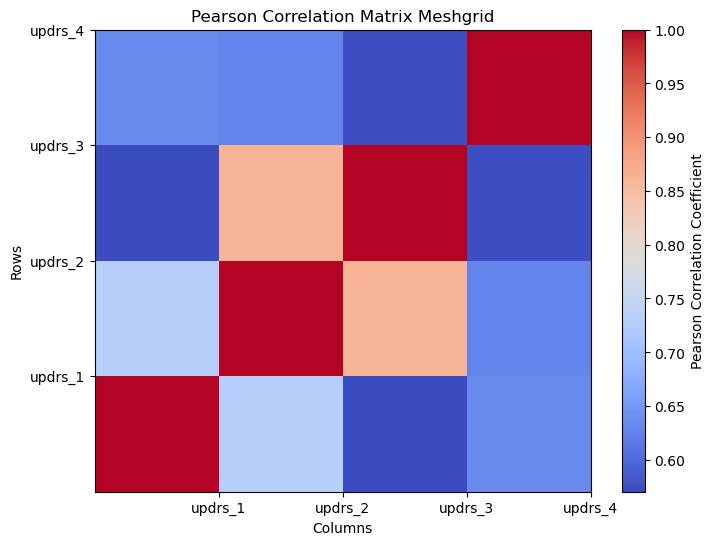

In [7]:
pearson_corr = max_updrs[[f'updrs_{i}' for i in (1, 2, 3, 4)]].corr()

# Step 3: Create meshgrid
x, y = np.meshgrid(np.arange(len(pearson_corr.columns)), np.arange(len(pearson_corr.index)))

# Step 4: Plot the meshgrid
plt.figure(figsize=(8, 6))
plt.pcolormesh(x, y, pearson_corr, cmap='coolwarm', shading='auto')
plt.colorbar(label='Pearson Correlation Coefficient')
plt.xticks(ticks=np.arange(len(pearson_corr.columns)) + 0.5, labels=pearson_corr.columns)
plt.yticks(ticks=np.arange(len(pearson_corr.index)) + 0.5, labels=pearson_corr.index)
plt.title('Pearson Correlation Matrix Meshgrid')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [8]:
max_updrs.groupby(['patient_group']).mean()[[f'updrs_{i}' for i in (1,2,3,4)]]

,updrs_1,updrs_2,updrs_3,updrs_4
patient_group,,,,
0,12.902256,13.278195,36.887218,4.714286
1,6.776596,1.840426,5.329787,0.138298
2,29.000000,33.000000,82.000000,14.500000
3,21.315789,25.315789,57.736842,7.736842


### Sample patients
propagation for a few sample patient profiles

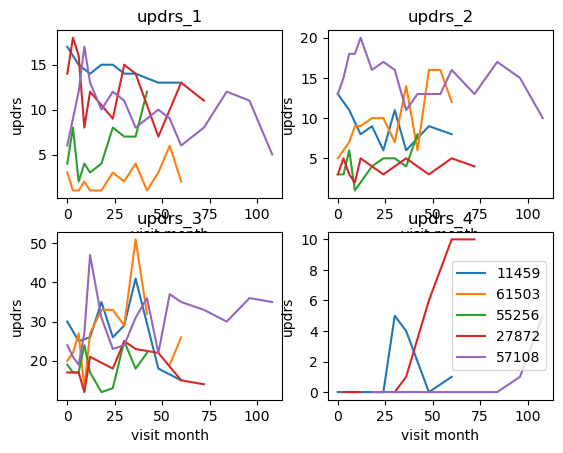

In [10]:
patient_55 = clinical_data[clinical_data['patient_id']==55]

sample_patients = clinical_data['patient_id'].sample(5)
patients = clinical_data[clinical_data['patient_id'].isin(sample_patients)].groupby('patient_id')

fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
# for each patient, for four dimensions, plot
for i in range(4):
    ax = ax_flat[i]
    assert isinstance(ax, Axes)
    for patient in sample_patients:
        patient_profile = clinical_data[clinical_data['patient_id'] == patient]
        updrs_dimension = patient_profile[['visit_month', f'updrs_{int(i+1)}']]
        updrs_dimension = updrs_dimension[updrs_dimension.notna().any(axis=1)]
        ax.plot(updrs_dimension['visit_month'], updrs_dimension[f'updrs_{int(i+1)}'], label=str(patient))
        ax.set(xlabel='visit month', ylabel='updrs')
        ax.set_title(f'updrs_{int(i+1)}')
        if i == 3:
            ax.legend()

Corrected plot with cumulative max applied.

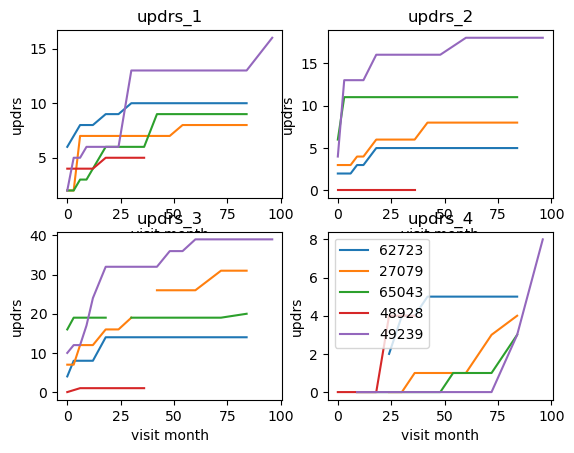

In [11]:
patient_55 = clinical_data[clinical_data['patient_id']==55]

sample_patients = clinical_data['patient_id'].sample(5)
patients = clinical_data[clinical_data['patient_id'].isin(sample_patients)].groupby('patient_id')

fig, axs = plt.subplots(2,2,)
ax_flat = axs.flat
# for each patient, for four dimensions, plot
for i in range(4):
    ax = ax_flat[i]
    assert isinstance(ax, Axes)
    for patient in sample_patients:
        patient_profile = clinical_data[clinical_data['patient_id'] == patient]
        updrs_dimension = patient_profile[['visit_month', f'updrs_{int(i+1)}']]
        updrs_dimension = updrs_dimension[updrs_dimension.notna().any(axis=1)]
        ax.plot(updrs_dimension['visit_month'], updrs_dimension[f'updrs_{int(i+1)}'].cummax(), label=str(patient))
        ax.set(xlabel='visit month', ylabel='updrs')
        ax.set_title(f'updrs_{int(i+1)}')
        if i == 3:
            ax.legend()

## B. Data Preprocessing
1. normalize "on_medication" status.
2. interpolation for null updrs values, keep track of interpolation.

In [12]:
# this function gets the change in UPDRS series, compared to previous month
def updrs_delta(feature: pd.Series, time: pd.Series = None) -> pd.Series:
    """
    input:
        `feature`: pandas.Series, feature to calculate delta upon
        `month`: pandas.Series, month of sampling
    output:
    * if month data is provided:
        `feature_delta`: delta value of d(updrs)/d(mo)
    * if month is `None`:
        `feature_diff`: pandas.Series, absolute difference of the current and previous sample
    """
    # delta value of updrs shift
    feature_diff = feature - feature.shift(1)
    # if month not provided, return absolute difference of change
    # useful if taking month data separately in analysis
    if time is None:
        return feature_diff
    # delta value of month
    d_time = time - time.shift(1)
    # divide by month value, to get speed of propagation
    feature_delta = feature_diff / d_time
    return feature_delta

def previous_n(feature: pd.Series, n: int = 3) -> pd.Series:
    """
    show previous n history, in a series of tuples
    input:
        `feature`: pandas.Series, feature to calculate 
    """

sample = clinical_data[:10]
sample_updrs = sample['updrs_1']
sample_month = sample['visit_month']

pd.DataFrame(
    {
        'current': sample_updrs,
        'previous': sample_updrs.shift(1),
        'month': sample_month,
        'delta': updrs_delta(sample_updrs, sample_month)

    }
)

,current,previous,month,delta
0,10.0,NaN,0,NaN
1,10.0,10.0,3,0.000000
2,8.0,10.0,6,-0.666667
3,8.0,8.0,9,0.000000
4,10.0,8.0,12,0.666667
5,7.0,10.0,18,-0.500000
6,16.0,7.0,24,1.500000
7,14.0,16.0,30,-0.333333
8,17.0,14.0,36,0.500000
9,12.0,17.0,42,-0.833333


In [13]:
clinical_data.isna().sum(axis=0)

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

### Experiment 1

**ignoring UPDRS 4**
UPDRS 4 has many missing data, so we will ignore for now.
UPDRS 4, defined as complications of therapy is dependent on clinical decision
so it's dependent on updrs 1,2,3

**removing null**
In updrs 1,2,3, 2615 records, has 2588 not containing null. We filter out the records containing null

**delta and previous state**

In the `clinical_data` table without null values, we will create following feature-columns:
- shift columns to get previous `visit_month` and `updrs_1,2,3`.
- group by `patient_id`.
- calculate delta value of month, `month_delta`, using `month - month_prev`.
- calculate delta value for UPDRS 1,2,3, using `(updrs_i - updrs_i_prev) / month_delta`.
- drop null rows, they should be first month which has no delta.
- delta values for UPDRS 1,2,3.

<!--NOTES:
check if groupby works.
analyzing MI do require records from all patients, single profile is too small.
if groupby doesn't work, iterate over profiles, and concatenate delta, prev into 
-->


In [14]:
print('original dataset:', clinical_data.shape)
print(
    'not null in updrs 1,2,3,4:',
    clinical_data[clinical_data.notna().all(axis=1)].shape)
print(
    'not null in updrs 1,2,3:',
    clinical_data[clinical_data[[f'updrs_{i}' for i in (1,2,3)]].notna().all(axis=1)].shape)

original dataset: (2615, 8)
not null in updrs 1,2,3,4: (1259, 8)
not null in updrs 1,2,3: (2588, 8)


In [15]:
# rename clinical data columns

# first, take a sample patient for delta-past analysis, take patient 55
clinical_data_e1 = clinical_data.copy()  # this df is for use by experiment 1 only.
clinical_data_e1.rename(
    columns={
        'upd23b_clinical_state_on_medication': 'on_medication',
        'visit_month': 'month'
        }, inplace=True)
# clinical_data_e1['on_medication'] = clinical_data_e1['on_medication'].map({'On': True, 'Off':False})
clinical_data_e1.drop(columns=['updrs_4', 'on_medication'])
clinical_data_e1_g = clinical_data_e1.groupby(['patient_id'])

# delta updrs
e1_transformed = {
    'month_delta': clinical_data_e1_g['month'].apply(updrs_delta),
}
e1_transformed.update({
    f'updrs_{i}': clinical_data_e1_g[f'updrs_{i}'].apply(
        lambda group: group.cummax()) for i in (1,2,3)
})
# previous updrs by shifting
e1_transformed.update({
    f'updrs_{i}_prev': e1_transformed[f'updrs_{i}'].shift(1) for i in (1,2,3)
})
# absolute updrs by subtraction
e1_transformed.update({
    f'updrs_{i}_delta': updrs_delta(e1_transformed[f'updrs_{i}']) for i in (1,2,3)
})
e1_transformed.update({
    f'updrs_{i}_dt': pd.Series.div(e1_transformed[f'updrs_{i}_delta'], e1_transformed['month_delta'])
    for i in (1,2,3)
})

# build the dataframe containing expanded features
df_e1 = pd.DataFrame({key: value for key, value in e1_transformed.items()})
df_e1 = df_e1[df_e1.notna().all(axis=1)]

In [ ]:
df_e1.head(10)

In [ ]:
df_e1.head(10)

1. get mutual information of UPDRS-1 with previous, $MI(x_i, x_{i-1})$

Text(0, 0.5, 'dx/dt for updrs 1')

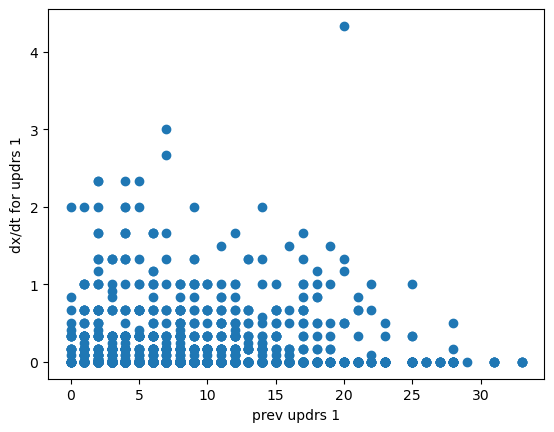

In [18]:
# visualizing the dx/dt (y) vs prev_x
plt.scatter(df_e1['updrs_1_prev'].tolist(), df_e1['updrs_1_dt'].tolist())
plt.xlabel('prev updrs 1')
plt.ylabel('dx/dt for updrs 1')

Text(0, 0.5, 'dx/dt updrs 3')

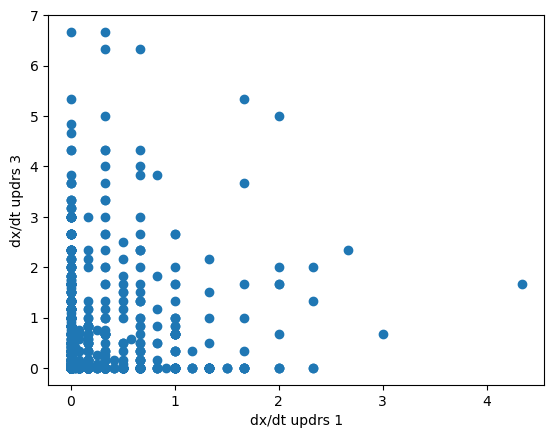

In [19]:
# plot of d updrs_1 / dt and d updrs_3 / dt relations
plt.scatter(df_e1['updrs_1_dt'].tolist(), df_e1['updrs_3_dt'].tolist())
plt.xlabel('dx/dt updrs 1')
plt.ylabel('dx/dt updrs 3')

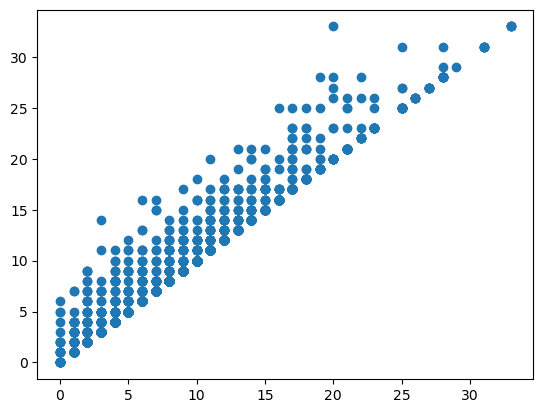

In [20]:
plt.scatter(df_e1['updrs_1_prev'].tolist(), df_e1['updrs_1'].tolist())


In [21]:
# mutual information using sklearn method
from sklearn.metrics import normalized_mutual_info_score as nmis

# mutual information between current propagation speed and previous propagation
print('UPDRS propagation speed from previous value:',
    nmis(df_e1['updrs_1_dt'].tolist(), df_e1['updrs_1_prev'].tolist()))


UPDRS propagation speed from previous value: 0.04778714909134881


g:\My Drive\CRS_CSYS5030\PythonEntropyCodeTemplates\.conda\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


In [22]:
nmis(df_e1['updrs_1_delta'].tolist(), df_e1['updrs_3_prev'].tolist())


0.0454137308260758

Mutual information MI(dx[i]/dt, x[i-1], dx[i-1]/dt)

In [25]:
# mutual information using jidt

# TODO: rewrite source destination data
# histories = (clinical_data_e1_g[f'updrs_{i}'].apply(
#         lambda group: group.shift(1)) for i in (1,2,3))

for i in (1,2,3):

    # A. entropy of propagation speed using Gaussian
    # 0. Load/prepare the data:
    variable = JArray(JDouble, 1)(df_e1[f'updrs_{i}_dt'].to_numpy())

    # 1. Construct the calculator:
    GaussEntropy = JPackage("infodynamics.measures.continuous.gaussian").EntropyCalculatorGaussian
    entropy_calc = GaussEntropy()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    entropy_calc.initialise()
    # 4. Supply the sample data:
    entropy_calc.setObservations(variable)
    # 5. Compute the estimate:
    entropy_value = entropy_calc.computeAverageLocalOfObservations()
    
    # B. mutual information of propagation speed and UPDRS
    # 0. Load/prepare the data:
    source = JArray(JDouble, 1)(df_e1[f'updrs_{i}_dt'].to_numpy())
    destination = JArray(JDouble, 1)(df_e1[f'updrs_{i}_prev'].to_numpy())
    # 1. Construct the calculator:
    Ksg = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
    ksg_calc = Ksg()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    ksg_calc.initialise()
    # 4. Supply the sample data:
    ksg_calc.setObservations(source, destination)
    # 5. Compute the estimate:
    mi_value = ksg_calc.computeAverageLocalOfObservations()

    # output results
    print("H_Gaussian(UPDRS-%s) = %.4f nats" %\
        (i, entropy_value))
    print("MI_Kraskov (KSG) alg. 1(UPDRS-%s, dx[i]/dt & x[i-1]) = %.4f nats" %\
        (i, mi_value))

H_Gaussian(UPDRS-1) = 0.2769 nats
MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0191 nats
H_Gaussian(UPDRS-2) = 0.2592 nats
MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.0166 nats
H_Gaussian(UPDRS-3) = 1.1040 nats
MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.0377 nats


Calculating time series entropy value using Kozachenko-Leonenko.

In [ ]:
Ksg = JPackage("infodynamics.measures.continuous.kraskov")\
    .MutualInfoCalculatorMultiVariateKraskov1
Kozachenko = JPackage("infodynamics.measures.continuous.kozachenko")\
.EntropyCalculatorMultiVariateKozachenko

for i in (1,2,3,4):

    # A. entropy of propagation speed using Gaussian
    # 0. Load/prepare the data:
    updrs_speed = df_e1[f'updrs_{i}_dt']
    updrs_prev = df_e1[f'updrs_{i}_prev']
    notna = updrs_speed.notna() & updrs_prev.notna()
    updrs_speed = updrs_speed[notna]
    updrs_prev = updrs_prev[notna]
    variable = JArray(JDouble, 1)(updrs_speed.to_numpy())

    # 1. Construct the calculator:
    entropy_calc = Ksg()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    entropy_calc.initialise()
    # 4. Supply the sample data:
    entropy_calc.setObservations(variable, variable)
    # 5. Compute the estimate:
    entropy_value = entropy_calc.computeAverageLocalOfObservations()
    
    # B. mutual information of propagation speed and UPDRS
    # 0. Load/prepare the data:
    source = JArray(JDouble, 1)(updrs_speed.to_numpy())
    destination = JArray(JDouble, 1)(updrs_prev.to_numpy())
    # 1. Construct the calculator:
    ksg_calc = Ksg()
    # 2. Set any properties to non-default values:
    # No properties were set to non-default values
    # 3. Initialise the calculator for (re-)use:
    ksg_calc.initialise()
    # 4. Supply the sample data:
    ksg_calc.setObservations(source, destination)
    # 5. Compute the estimate:
    mi_value = ksg_calc.computeAverageLocalOfObservations()

    # output results
    print("H_KSG(UPDRS-%s) = %.4f nats" %\
        (i, entropy_value))
    print("MI_Kraskov (KSG) alg. 1(UPDRS-%s, dx[i]/dt & x[i-1]) = %.4f nats" %\
        (i, mi_value))

H_KSG(UPDRS-1) = -15.3833 nats
MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.2969 nats
H_KSG(UPDRS-2) = -15.4949 nats
MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.3550 nats
H_KSG(UPDRS-3) = -15.1801 nats
MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.3934 nats
H_KSG(UPDRS-4) = -16.2712 nats
MI_Kraskov (KSG) alg. 1(UPDRS-4, dx[i]/dt & x[i-1]) = 0.2360 nats


Note previous entropy using KSG is computed on all patient profiles combined. Taking individual patient data:

In [14]:
sample_patients = [
    (df_e1[df_e1['patient_id'] == sample], sample)
    for sample in df_e1['patient_id'].sample(20)
]
patient_entropies = []
patient_mis = []

for i in (1,2,3,4):
    for sample_patient, patient_id in sample_patients:
        # A. entropy of propagation speed using Gaussian
        # 0. Load/prepare the data:
        updrs_speed = sample_patient[f'updrs_{i}_dt']
        updrs_prev = sample_patient[f'updrs_{i}_prev']
        notna = updrs_speed.notna() & updrs_prev.notna()
        updrs_speed = updrs_speed[notna]
        updrs_prev = updrs_prev[notna]
        variable = JArray(JDouble, 1)(updrs_speed.to_numpy())

        # 1. Construct the calculator:
        entropy_calc = Ksg()
        # 2. Set any properties to non-default values:
        # No properties were set to non-default values
        # 3. Initialise the calculator for (re-)use:
        entropy_calc.initialise()
        # 4. Supply the sample data:
        entropy_calc.setObservations(variable, variable)
        # 5. Compute the estimate:
        entropy_value = entropy_calc.computeAverageLocalOfObservations()
        
        # B. mutual information of propagation speed and UPDRS
        # 0. Load/prepare the data:
        source = JArray(JDouble, 1)(updrs_speed.to_numpy())
        destination = JArray(JDouble, 1)(updrs_prev.to_numpy())
        # 1. Construct the calculator:
        ksg_calc = Ksg()
        # 2. Set any properties to non-default values:
        # No properties were set to non-default values
        # 3. Initialise the calculator for (re-)use:
        ksg_calc.initialise()
        # 4. Supply the sample data:
        ksg_calc.setObservations(source, destination)
        # 5. Compute the estimate:
        mi_value = ksg_calc.computeAverageLocalOfObservations()
        # append to list
        patient_entropies.append(entropy_value)
        patient_mis.append(mi_value)
    # output results
    print("H_KL(UPDRS-%s) mean = %.4f nats" %\
        (i, np.mean(patient_entropies)))
    print("MI_Kraskov (KSG) mean (UPDRS-%s, dx[i]/dt & x[i-1]) = %.4f nats" %\
        (i, np.mean(mi_value)))

H_KL(UPDRS-1) mean = 0.8950 nats
MI_Kraskov (KSG) mean (UPDRS-1, dx[i]/dt & x[i-1]) = 0.5077 nats
H_KL(UPDRS-2) mean = 0.8220 nats
MI_Kraskov (KSG) mean (UPDRS-2, dx[i]/dt & x[i-1]) = 0.1491 nats
H_KL(UPDRS-3) mean = 0.7879 nats
MI_Kraskov (KSG) mean (UPDRS-3, dx[i]/dt & x[i-1]) = 0.4430 nats
H_KL(UPDRS-4) mean = 0.7066 nats
MI_Kraskov (KSG) mean (UPDRS-4, dx[i]/dt & x[i-1]) = 0.1324 nats


Conditional mutual information, given patient group in 0, 1 and 2.

In [ ]:
Ksg = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
df_e1_group = pd.merge(df_e1, max_updrs['patient_group'],left_on=['patient_id'], right_on=['patient_id'])

for group in df_e1_group['patient_group'].unique():
    print(f"group {group}")
    df_in_group = df_e1_group[df_e1_group['patient_group']==group]
    for i in (1,2,3):
        print(f'\tUPDRS {i}')
        # A. entropy of propagation speed using Gaussian
        # 0. Load/prepare the data:
        variable = JArray(JDouble, 1)(df_in_group[f'updrs_{i}_dt'].to_numpy())

        # 1. Construct the calculator:
        # GaussEntropy = JPackage("infodynamics.measures.continuous.gaussian").EntropyCalculatorGaussian
        entropy_calc = Ksg()
        # 2. Set any properties to non-default values:
        # No properties were set to non-default values
        # 3. Initialise the calculator for (re-)use:
        entropy_calc.initialise()
        # 4. Supply the sample data:
        entropy_calc.setObservations(variable, variable)
        # 5. Compute the estimate:
        entropy_value = entropy_calc.computeAverageLocalOfObservations()
        
        # B. mutual information of propagation speed and UPDRS
        
        source = JArray(JDouble, 1)(df_in_group[f'updrs_{i}_dt'].to_numpy())
        destination = JArray(JDouble, 1)(df_in_group[f'updrs_{i}_prev'].to_numpy())
        # 1. Construct the calculator:
        ksg_calc = Ksg()
        # 2. Set any properties to non-default values:
        # No properties were set to non-default values
        # 3. Initialise the calculator for (re-)use:
        ksg_calc.initialise()
        # 4. Supply the sample data:
        ksg_calc.setObservations(source, destination)
        # 5. Compute the estimate:
        mi_value = ksg_calc.computeAverageLocalOfObservations()

        # output results
        print("\tH_KSG(dx[i]/dt) = %.4f nats" %\
            (entropy_value))
        print("\tMI_Kraskov (KSG) alg. 1(UPDRS-%s, dx[i]/dt & x[i-1]) = %.4f nats" %\
            (i, mi_value))

group 3
	UPDRS 1
	H_Gaussian(dx[i]/dt) = 0.7875 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0769 nats
	UPDRS 2
	H_Gaussian(dx[i]/dt) = 0.6802 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.0741 nats
	UPDRS 3
	H_Gaussian(dx[i]/dt) = 1.3967 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.1520 nats
group 0
	UPDRS 1
	H_Gaussian(dx[i]/dt) = 0.2527 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0189 nats
	UPDRS 2
	H_Gaussian(dx[i]/dt) = 0.3019 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = 0.0371 nats
	UPDRS 3
	H_Gaussian(dx[i]/dt) = 1.1965 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-3, dx[i]/dt & x[i-1]) = 0.0403 nats
group 1
	UPDRS 1
	H_Gaussian(dx[i]/dt) = -0.1442 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-1, dx[i]/dt & x[i-1]) = 0.0529 nats
	UPDRS 2
	H_Gaussian(dx[i]/dt) = -0.6768 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-2, dx[i]/dt & x[i-1]) = -0.0057 nats
	UPDRS 3
	H_Gaussian(dx[i]/dt) = -0.1469 nats
	MI_Kraskov (KSG) alg. 1(UPDRS-

In [27]:
df_e1_group['patient_group'].unique()

array([3, 0, 1, 2], dtype=int64)

In [28]:
pd.Series([1,3,5,2,np.nan, np.nan]).fillna(0).cummax(skipna=False)

0    1.0
1    3.0
2    5.0
3    5.0
4    5.0
5    5.0
dtype: float64

Feature extraction for propagation and plateau patterns

In [48]:
df_e2 = df_e1.reset_index()
# track the propagation and plateau periods
propagation_table = {
    "patient_id": [],
    "start_updrs": [],
    "delta": [],
    "duration": []
}

# iterate through the records to get propagations and plateaus
for patient_id in df_e2['patient_id'].unique():
    df_patient = df_e2[df_e2['patient_id']==patient_id]
    current_increasing = True if df_patient['updrs_1_dt'].iloc[0] > 0 else False
    start_updrs = df_patient['updrs_1'].iloc[0]
    duration = 0
    delta = 0
    record_last = True  # whether to record last round
    for _, row in df_patient.iterrows():
        if current_increasing:
            if row['updrs_1_delta'] > 0.01:
                duration += row['month_delta']
                delta += row['updrs_1_delta']
                record_last = True
                continue
            else:
                current_increasing = False
                start_uprs = row['updrs_1']
        else:
            if row['updrs_1_delta'] <= 0.01:
                duration += row['month_delta']
                record_last = True
                continue
            else:
                current_increasing = True
        propagation_table["patient_id"].append(patient_id)
        propagation_table["start_updrs"].append(start_updrs)
        propagation_table["delta"].append(delta)
        propagation_table["duration"].append(duration)
        start_uprs = row['updrs_1']
        delta = row['updrs_1_delta']
        duration = row['month_delta']
        record_last = False
    # after finishing the rows in each patient
    # if last propagation is not recorded, record it below
    # FIXME: It's WET
    if record_last:
        propagation_table["patient_id"].append(patient_id)
        propagation_table["start_updrs"].append(start_updrs)
        propagation_table["delta"].append(delta)
        propagation_table["duration"].append(duration)
        start_uprs = row['updrs_1']
    break

